Use conda environment `conda_envs/cool.yml` to run this notebook.

In [1]:
import pandas as pd
import cooler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from os import listdir, system, path
import re

# Set input parameters

In [2]:
# 1) Brain region
# regs = ["MTG", "LEC", 'A46', 'FI', 'M1C'] # brain regions
regs = ["LEC"] # brain regions


# 2) Cell types
"""
Choose Cell Classes or Major Types of cells of interest.
See Table S4 for details.

Major type codes:
IN = "Inhibitory/non-telencephalic neurons"
EN = "Telencephalic excitatory neurons"
NN = "Non-neuronal Cells"

Examples:
1) Take "Inhibitory/non-telencephalic neurons"
cts = ['IN']

2) Take Astrocytes and Oligodendrocyes
cts = ['ASC', 'ODC']

3) Take "Telencephalic excitatory neurons" and "Astrocytes"
cts = ['EN', 'ASC']

4) Take all cell types
cts = ['all']
"""
cts = ['IN']

# 3) Path to Suppl. Tables from Tian2023
table_s4_path = "/tank/projects/tian2023/table-S4-cell-type-taxonomy.tsv.gz"
table_s5_path = "/tank/projects/tian2023/table-S5-meta.csv.gz"

# 4) Path to directory with downloaded pair files
pair_dir = "/tank/projects/tian2023/contacts/"

# 5) Required cooler resolution
res = 10_000

# 6) Path to file with chromosome sizes
chrom_sizes = '/tank/projects/tian2023/hg38.reduced.chrom.sizes'

# 7) Limit number of cells. If 0, then use all available cells.
ncells = 14_145

In [3]:
s5 = pd.read_table(table_s5_path, sep=',')
s5.head()

/tmp/ipykernel_330597/4116529416.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  s5 = pd.read_table(table_s5_path, sep=',')


,Unnamed: 0,mCCCFrac,mCGFrac,mCHFrac,FinalmCReads,pool,Donor #,Region,tech,SubType
0,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A1,0.0061,0.77,0.01,2120000.0,m3c16,2,BNST,m3C,93.0
1,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A13,0.0049,0.77,0.01,2250000.0,m3c16,2,BNST,m3C,20.0
2,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A14,0.0052,0.75,0.01,2660000.0,m3c16,2,BNST,m3C,104.0
3,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A2,0.0088,0.75,0.01,2370000.0,m3c16,2,BNST,m3C,101.0
4,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-B1,0.0051,0.76,0.02,780000.0,m3c16,2,BNST,m3C,98.0


In [4]:
s4 = pd.read_table(table_s4_path)
s4.head()

,Unnamed: 0,SubType,MajorType,CellClass,Note
0,1,CB_0,CB,Inhibitory/non-telencephalic neurons,Granule cells from cerebellum
1,2,CB_1,CB,Inhibitory/non-telencephalic neurons,Granule cells from cerebellum
2,3,CB_2,CB,Inhibitory/non-telencephalic neurons,Granule cells from cerebellum
3,4,CHD7_0,Chd7,Inhibitory/non-telencephalic neurons,Neurons from BF/BN with gene CHD7 hypomethylated
4,5,CHD7_1,Chd7,Inhibitory/non-telencephalic neurons,Neurons from BF/BN with gene CHD7 hypomethylated


In [7]:
s4['CellClass'].unique()

array(['Inhibitory/non-telencephalic neurons', 'Non-neuronal Cells',
       'Telencephalic excitatory neurons'], dtype=object)

In [3]:
def make_clr(regs, cts, clr_minres, ncells=0, pair_dir="/tank/projects/tian2023/contacts/",
             chrom_sizes='/tank/projects/tian2023/hg38.reduced.chrom.sizes',
             table_s4_path="/tank/projects/tian2023/table-S4-cell-type-taxonomy.tsv.gz",
             table_s5_path = "/tank/projects/tian2023/table-S5-meta.csv.gz",
             cell_lst_fp = '/tank/projects/tian2023/filelist.txt', zoomify=True,
             zoomify_nproc=5, upload2higlass=False):
    
    # Read table s4 with subtype description
    table_s4 = pd.read_table(table_s4_path, index_col=0)
    table_s4['CellClass'] = table_s4['CellClass'].map({
        "Inhibitory/non-telencephalic neurons": 'IN',
        "Telencephalic excitatory neurons": 'EN',
        "Non-neuronal Cells": 'NN'
    })
    
    # Load metadata table
    table_s5 = pd.read_table(table_s5_path, index_col=0, sep=',')
    table_s5 = table_s5.loc[table_s5['tech'] == 'm3C']
    
    # Get required subtype ids
    subts = table_s4.loc[table_s4['MajorType'].isin(cts) |
                         table_s4['CellClass'].isin(cts)].index

    # Select cells with required brain region and cell subtype
    if 'all' in cts:
        cell_names = list(table_s5.loc[table_s5['Region'].isin(regs)].index)
    else:
        cell_names = list(table_s5.loc[table_s5['Region'].isin(regs) &
                                       table_s5['SubType'].isin(subts)].index)

    print("Number of cells:", len(cell_names))
    
    # Keep cells that were already downloaded
    dwn_cellfn = listdir(pair_dir) # cell filename
    dwn_celln = [
        re.sub('^GSM[0-9]*_|.3C.contact.tsv.gz$', '', fn) for fn in dwn_cellfn
    ] # cell name
    dwn_dict = dict(zip(dwn_celln, dwn_cellfn)) # match cell "name" and "filename"

    avail_cells = list(set(dwn_celln) & set(cell_names))
    print("Number of available cells:", len(avail_cells), "out of", len(cell_names))

    if (ncells != 0) & (ncells < len(avail_cells)): # limit number of cells
        avail_cells = np.random.choice(avail_cells, size=ncells, replace=False)

    print("Using", len(avail_cells), "cells")
    
    # Concatenate ".3C.contact.tsv.gz" files into one
    # Might take several minutes

    avail_fn = [dwn_dict[name] for name in avail_cells]
    avail_fpath = [pair_dir + name for name in avail_fn]
    pair_out_fn = "_".join(regs) + '.' + '_'.join(cts) + f".{int(len(avail_cells))}_cells" + '.3C.contact.tsv.gz'

    # Save cell file names to a file
    with open(cell_lst_fp, 'w') as fp:
        for fpath in avail_fpath:
            fp.write("%s\n" % fpath)

    # system("zcat " + ' '.join(avail_fpath) + ' | gzip > ' + pair_out_fn)
    system(f"xargs cat < {cell_lst_fp} > {pair_out_fn}")
    
    # CLI command to create a cooler file
    clr_out_fn = "_".join(regs) + '.' + '_'.join(cts) + f".{int(len(avail_cells))}_cells" + \
                 f".{clr_minres // 1000}kb" + '.cool'
    clr_exec_path = '/opt/anaconda/bin/cooler'
    system(f"{clr_exec_path} cload pairs --assembly hg38 -c1 2 -p1 3 -c2 6 -p2 7 \
                    {chrom_sizes}:{int(clr_minres)} {pair_out_fn} {clr_out_fn}")
    if path.exists(clr_out_fn):
        system(f"rm {pair_out_fn}")
    
    # balance and zoomify cooler
    if zoomify:
        system(f"{clr_exec_path} zoomify -p {zoomify_nproc} -r {clr_minres}N --balance {clr_out_fn}")
    else:
        system(f"{clr_exec_path} balance {clr_out_fn}")
    
    # upload2higlass
    if upload2higlass:
        mcool_fn = re.sub(".cool$", ".mcool", clr_out_fn)
        system(f"cp {mcool_fn} /tank/hg-tmp/{mcool_fn}")
        system(
            f"docker exec higlass-container python higlass-server/manage.py ingest_tileset \
                --filename /tmp/{mcool_fn} \
                --filetype cooler \
                --datatype matrix \
                --coordSystem hg38 \
                --name {mcool_fn} \
                --project 'Tian et al. 2023'"
        )
        system(f"rm /tank/hg-tmp/{mcool_fn}")
        
    return

In [32]:
cts_minres = [
#     (['Lamp5', 'Lamp5-Lhx6'], 50_000), 
#     (['Lamp5'], 100_000), 
#     (['Lamp5-Lhx6'], 100_000), 
#     (['Pvalb', 'Pvalb-ChC'], 50_000), 
#     (['Sncg'], 50_000), 
#     (['Sst'], 20_000), 
#     (['Vip'], 20_000), 
    (['L2-3-IT'], 10_000), 
    (['L4-IT'], 20_000), 
    (['L5-IT'], 20_000)
]

for cts, clr_minres in cts_minres:
    print(cts, clr_minres)
    make_clr(['MTG'], cts, clr_minres, zoomify_nproc=5, upload2higlass=True)

['L2-3-IT'] 10000


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/ipykernel_launcher.py:16: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()


Number of cells: 1655
Number of available cells: 1655 out of 1655
Using 1655 cells


  is_cat = pd.api.types.is_categorical(bins["chrom"])

INFO:cooler.create:Writing chunk 0: /tank/projects/tian2023/tmpmpqn4yli.multi.cool::0
INFO:cooler.create:Creating cooler at "/tank/projects/tian2023/tmpmpqn4yli.multi.cool::/0"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Writing chunk 1: /tank/projects/tian2023/tmpmpqn4yli.multi.cool::1
INFO:cooler.create:Creating cooler at "/tank/projects/tian2023/tmpmpqn4yli.multi.cool::/1"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Writing chunk 2: /tank/projects/tian2023/tmpmpqn4yli.multi.cool::2
INFO:cooler.create:Creating cooler at "/tank/projects/tian2023/tmpmpqn4yli.multi.cool::/2"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.cr

INFO:cooler.create:Writing chunk 23: /tank/projects/tian2023/tmpmpqn4yli.multi.cool::23
INFO:cooler.create:Creating cooler at "/tank/projects/tian2023/tmpmpqn4yli.multi.cool::/23"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Writing chunk 24: /tank/projects/tian2023/tmpmpqn4yli.multi.cool::24
INFO:cooler.create:Creating cooler at "/tank/projects/tian2023/tmpmpqn4yli.multi.cool::/24"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Writing chunk 25: /tank/projects/tian2023/tmpmpqn4yli.multi.cool::25
INFO:cooler.create:Creating cooler at "/tank/projects/tian2023/tmpmpqn4yli.multi.cool::/25"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing

INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Merging into MTG.L2-3-IT.1655_cells.10kb.cool
INFO:cooler.create:Creating cooler at "MTG.L2-3-IT.1655_cells.10kb.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:nnzs: [11087733, 11216411, 11043278, 11101842, 11068347, 11078465, 10960154, 11210107, 11212019, 11157959, 11103959, 11016363, 11187573, 11137562, 10965023, 11151274, 11098898, 11266183, 11131347, 11097801, 11090734, 11115781, 11084807, 11021537, 11174302, 11073570, 11086922, 11152000, 11032903, 11055719, 11144178, 11168910, 11118410, 11013797, 11200981, 11149362, 11121948, 11190203, 11073424, 11105571, 11002174, 11023432, 11124680, 11032182, 11038316, 10977020, 2690920]
INFO:cooler.reduce:current: [324392, 330996, 319799, 331696, 320810, 318472, 325569, 329758, 325587, 333803, 324148, 312708, 325907, 336266, 312713, 329218, 322701, 328696, 330453, 328868, 321519, 

INFO:cooler.reduce:current: [5858695, 5869284, 5834241, 5793008, 5826010, 5822424, 5771800, 5909427, 5899670, 5891742, 5815731, 5795076, 5865595, 5878922, 5749423, 5878109, 5769513, 5991049, 5842164, 5826720, 5847371, 5847353, 5819692, 5785889, 5903416, 5831134, 5774112, 5860406, 5878682, 5786163, 5833381, 5867775, 5887374, 5813680, 5908648, 5860872, 5794622, 5911219, 5821303, 5864618, 5774550, 5781043, 5868758, 5795303, 5802238, 5771389, 1399902]
INFO:cooler.reduce:current: [6184217, 6199953, 6156674, 6113436, 6149531, 6147675, 6093013, 6242478, 6222815, 6218576, 6137046, 6116739, 6199742, 6201507, 6071658, 6203889, 6090263, 6321051, 6170916, 6151650, 6171876, 6175333, 6133461, 6106850, 6234369, 6154151, 6091544, 6183502, 6194328, 6119204, 6155104, 6194545, 6211760, 6133491, 6242558, 6178386, 6125870, 6234647, 6155459, 6188243, 6095656, 6104546, 6195565, 6107484, 6127728, 6089353, 1480901]
INFO:cooler.reduce:current: [6507891, 6527806, 6474600, 6444047, 6473163, 6471361, 6415457, 6572

INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.cli.zoomify:Recursively aggregating "MTG.L2-3-IT.1655_cells.10kb.cool"
INFO:cooler.cli.zoomify:Writing to "MTG.L2-3-IT.1655_cells.10kb.mcool"
  warnings.warn(

INFO:cooler.reduce:Copying base matrices and producing 10 new zoom levels.
INFO:cooler.reduce:Bin size: 10000
INFO:cooler.reduce:Aggregating from 10000 to 20000.
  is_cat = pd.api.types.is_categorical(bins["chrom"])

INFO:cooler.create:Creating cooler at "MTG.L2-3-IT.1655_cells.10kb.mcool::/resolutions/20000"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:20002267 30003402
INFO:cooler.reduce:0 10004143
INFO:cooler.reduce:30003402 40002770
INFO:cooler.reduce:10004143 20002267
INFO:cooler.reduce:40002770 50000272
INFO:cooler.reduce:70003011 80000221
INFO:cooler.reduce:60000883 70003011
INFO:cooler.reduce:90001973 100001018
INFO:cooler.reduce:50000272 60000883
INFO:cooler.reduce:8000

INFO:cooler.reduce:10006615 16774104
INFO:cooler.reduce:0 10006615
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.reduce:Aggregating from 1000000 to 2000000.
  is_cat = pd.api.types.is_categorical(bins["chrom"])

INFO:cooler.create:Creating cooler at "MTG.L2-3-IT.1655_cells.10kb.mcool::/resolutions/2000000"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:0 4350641
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.reduce:Aggregating from 1000000 to 5000000.
  is_cat = pd.api.types.is_categorical(bins["chrom"])

INFO:cooler.create:Creating cooler at "MTG.L2-3-IT.1655_cells.10kb.mcool::/resolutions/5000000"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:0 4350641
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.reduce:Aggregating from 5000000 to 10000000.
  i

INFO:cooler.balance:variance is 121464742.51225445
INFO:cooler.balance:variance is 25227758.28181734
INFO:cooler.balance:variance is 6026964.8494231505
INFO:cooler.balance:variance is 3323795.3269216777
INFO:cooler.balance:variance is 1088091.6057606756
INFO:cooler.balance:variance is 523253.71487971634
INFO:cooler.balance:variance is 197669.46139576213
INFO:cooler.balance:variance is 88733.0839333713
INFO:cooler.balance:variance is 35782.3564143668
INFO:cooler.balance:variance is 15579.726960553862
INFO:cooler.balance:variance is 6474.3084081966235
INFO:cooler.balance:variance is 2783.382520388723
INFO:cooler.balance:variance is 1173.0085458418425
INFO:cooler.balance:variance is 501.84552759416374
INFO:cooler.balance:variance is 212.92330351614066
INFO:cooler.balance:variance is 90.95088802652877
INFO:cooler.balance:variance is 38.71934509578512
INFO:cooler.balance:variance is 16.534492832373324
INFO:cooler.balance:variance is 7.051753137272261
INFO:cooler.balance:variance is 3.011904

INFO:cooler.balance:variance is 1582215.0952775858
INFO:cooler.balance:variance is 154186.35924972416
INFO:cooler.balance:variance is 15055.385846224357
INFO:cooler.balance:variance is 1480.7171214363946
INFO:cooler.balance:variance is 146.1732294693049
INFO:cooler.balance:variance is 14.483975479545144
INFO:cooler.balance:variance is 1.4396361397052775
INFO:cooler.balance:variance is 0.14351161179015173
INFO:cooler.balance:variance is 0.014345712621819372
INFO:cooler.balance:variance is 0.0014379083634998725
INFO:cooler.balance:variance is 0.00014451146828954283
INFO:cooler.balance:variance is 1.45625040243021e-05
INFO:cooler.balance:variance is 1.4714292225441455e-06
INFO:cooler.cli.zoomify:Balancing zoom level with bin size 10000000
INFO:cooler.cli.balance:Balancing "MTG.L2-3-IT.1655_cells.10kb.mcool::resolutions/10000000"
INFO:cooler.balance:variance is 136675230532.24715
INFO:cooler.balance:variance is 5588069872.990024
INFO:cooler.balance:variance is 321072111.77805966
INFO:coole

['L4-IT'] 20000
Number of cells: 722
Number of available cells: 722 out of 722
Using 722 cells


  is_cat = pd.api.types.is_categorical(bins["chrom"])

INFO:cooler.create:Writing chunk 0: /tank/projects/tian2023/tmpahvjk290.multi.cool::0
INFO:cooler.create:Creating cooler at "/tank/projects/tian2023/tmpahvjk290.multi.cool::/0"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Writing chunk 1: /tank/projects/tian2023/tmpahvjk290.multi.cool::1
INFO:cooler.create:Creating cooler at "/tank/projects/tian2023/tmpahvjk290.multi.cool::/1"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Writing chunk 2: /tank/projects/tian2023/tmpahvjk290.multi.cool::2
INFO:cooler.create:Creating cooler at "/tank/projects/tian2023/tmpahvjk290.multi.cool::/2"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.cr

INFO:cooler.reduce:current: [3011825, 3011496, 2999513, 3004580, 2994137, 3020551, 3003486, 2995704, 3025843, 3009361, 3016533, 2985323, 3019897, 3013923, 2984208, 3057263, 3023570, 3005986, 3021888, 2789922]
INFO:cooler.reduce:current: [3764272, 3747351, 3739024, 3756958, 3748000, 3764055, 3735138, 3747407, 3795599, 3765142, 3768027, 3737496, 3788154, 3748592, 3746076, 3822859, 3789857, 3764269, 3776661, 3489961]
INFO:cooler.reduce:current: [4526906, 4497961, 4472862, 4494109, 4505281, 4513064, 4464484, 4500389, 4564406, 4502938, 4534824, 4488941, 4552917, 4481372, 4512283, 4584763, 4542495, 4523870, 4533638, 4195752]
INFO:cooler.reduce:current: [5274019, 5275691, 5208658, 5238300, 5273321, 5270710, 5200405, 5247164, 5335904, 5250554, 5290258, 5234935, 5312211, 5219360, 5269665, 5341339, 5279100, 5291799, 5286162, 4892485]
INFO:cooler.reduce:current: [6035287, 6025305, 5954008, 5982145, 6042464, 6006854, 5945072, 5995542, 6079782, 6008974, 6059222, 5979282, 6052299, 5975778, 6033904, 

INFO:cooler.create:Creating cooler at "MTG.L4-IT.722_cells.20kb.mcool::/resolutions/4000000"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:0 1113650
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.reduce:Aggregating from 2000000 to 10000000.
  is_cat = pd.api.types.is_categorical(bins["chrom"])

INFO:cooler.create:Creating cooler at "MTG.L4-IT.722_cells.20kb.mcool::/resolutions/10000000"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:0 1113650
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.cli.zoomify:Balancing zoom level with bin size 20000
INFO:cooler.cli.balance:Balancing "MTG.L4-IT.722_cells.20kb.mcool::resolutions/20000"
INFO:cooler.balance:variance is 2896312.3118027174
INFO:cooler.balance:variance is 315721.84365928516
INFO:cooler.balance:variance is 79740.28469269906
INFO:c

INFO:cooler.balance:variance is 132363449.71185508
INFO:cooler.balance:variance is 32511655.53069469
INFO:cooler.balance:variance is 6465003.469149045
INFO:cooler.balance:variance is 2508518.0579787074
INFO:cooler.balance:variance is 688564.1199526101
INFO:cooler.balance:variance is 240270.9419898793
INFO:cooler.balance:variance is 74095.40593475384
INFO:cooler.balance:variance is 24802.123125685797
INFO:cooler.balance:variance is 7965.761958965173
INFO:cooler.balance:variance is 2629.933992288587
INFO:cooler.balance:variance is 856.7056666284034
INFO:cooler.balance:variance is 281.6858594534945
INFO:cooler.balance:variance is 92.22763316038336
INFO:cooler.balance:variance is 30.293633842170294
INFO:cooler.balance:variance is 9.937830516587345
INFO:cooler.balance:variance is 3.2638607239690582
INFO:cooler.balance:variance is 1.0715826906037822
INFO:cooler.balance:variance is 0.35197470896993066
INFO:cooler.balance:variance is 0.11560377764888324
INFO:cooler.balance:variance is 0.037976

['L5-IT'] 20000
Number of cells: 587
Number of available cells: 587 out of 587
Using 587 cells


  is_cat = pd.api.types.is_categorical(bins["chrom"])

INFO:cooler.create:Writing chunk 0: /tank/projects/tian2023/tmp31cqqdak.multi.cool::0
INFO:cooler.create:Creating cooler at "/tank/projects/tian2023/tmp31cqqdak.multi.cool::/0"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Writing chunk 1: /tank/projects/tian2023/tmp31cqqdak.multi.cool::1
INFO:cooler.create:Creating cooler at "/tank/projects/tian2023/tmp31cqqdak.multi.cool::/1"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Writing chunk 2: /tank/projects/tian2023/tmp31cqqdak.multi.cool::2
INFO:cooler.create:Creating cooler at "/tank/projects/tian2023/tmp31cqqdak.multi.cool::/2"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.cr

INFO:cooler.reduce:Aggregating from 20000 to 40000.
  is_cat = pd.api.types.is_categorical(bins["chrom"])

INFO:cooler.create:Creating cooler at "MTG.L5-IT.587_cells.20kb.mcool::/resolutions/40000"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:10000848 20001055
INFO:cooler.reduce:30000570 40001699
INFO:cooler.reduce:40001699 50000985
INFO:cooler.reduce:0 10000848
INFO:cooler.reduce:20001055 30000570
INFO:cooler.reduce:50000985 60001063
INFO:cooler.reduce:90000680 100000131
INFO:cooler.reduce:80000319 90000680
INFO:cooler.reduce:60001063 70001612
INFO:cooler.reduce:70001612 80000319
INFO:cooler.reduce:100000131 101425170
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.reduce:Aggregating from 20000 to 100000.
  is_cat = pd.api.types.is_categorical(bins["chrom"])

INFO:cooler.create:Creating cooler at "MTG.L5-IT.587_cells.20kb.mcool::/resolutions/100000"
INFO:cooler.create:Writing chrom

INFO:cooler.balance:variance is 647525.403632819
INFO:cooler.balance:variance is 163627.27352041757
INFO:cooler.balance:variance is 103068.20433257372
INFO:cooler.balance:variance is 35491.16693801008
INFO:cooler.balance:variance is 19259.33389481696
INFO:cooler.balance:variance is 7722.708993431944
INFO:cooler.balance:variance is 3865.5031575703283
INFO:cooler.balance:variance is 1670.846101728406
INFO:cooler.balance:variance is 804.0853878286262
INFO:cooler.balance:variance is 360.7682875906161
INFO:cooler.balance:variance is 170.46462560099636
INFO:cooler.balance:variance is 77.92582085338164
INFO:cooler.balance:variance is 36.52133278782197
INFO:cooler.balance:variance is 16.85496925337746
INFO:cooler.balance:variance is 7.87279451704265
INFO:cooler.balance:variance is 3.651481874840282
INFO:cooler.balance:variance is 1.7035264523427203
INFO:cooler.balance:variance is 0.7922470803737912
INFO:cooler.balance:variance is 0.3695116979982344
INFO:cooler.balance:variance is 0.17211133345

INFO:cooler.balance:variance is 768260298.2968291
INFO:cooler.balance:variance is 85581052.24275883
INFO:cooler.balance:variance is 11053981.244805666
INFO:cooler.balance:variance is 1900270.2283315419
INFO:cooler.balance:variance is 302376.09014116885
INFO:cooler.balance:variance is 50485.93643704562
INFO:cooler.balance:variance is 8347.491189704937
INFO:cooler.balance:variance is 1394.0352289403693
INFO:cooler.balance:variance is 233.04334856942168
INFO:cooler.balance:variance is 39.10057869624142
INFO:cooler.balance:variance is 6.5751533783896114
INFO:cooler.balance:variance is 1.1084491322343455
INFO:cooler.balance:variance is 0.18728763066921023
INFO:cooler.balance:variance is 0.03171630105372321
INFO:cooler.balance:variance is 0.005382868856841621
INFO:cooler.balance:variance is 0.0009155762897005292
INFO:cooler.balance:variance is 0.00015606887749418968
INFO:cooler.balance:variance is 2.666071066902385e-05
INFO:cooler.balance:variance is 4.564075008443956e-06
INFO:cooler.cli.zoo

# Read tables with metadata

In [5]:
# Read table s4 with subtype description
table_s4 = pd.read_table(table_s4_path, index_col=0)
table_s4['CellClass'] = table_s4['CellClass'].map({
    "Inhibitory/non-telencephalic neurons": 'IN',
    "Telencephalic excitatory neurons": 'EN',
    "Non-neuronal Cells": 'NN'
})
table_s4.head()

,SubType,MajorType,CellClass,Note
1,CB_0,CB,IN,Granule cells from cerebellum
2,CB_1,CB,IN,Granule cells from cerebellum
3,CB_2,CB,IN,Granule cells from cerebellum
4,CHD7_0,Chd7,IN,Neurons from BF/BN with gene CHD7 hypomethylated
5,CHD7_1,Chd7,IN,Neurons from BF/BN with gene CHD7 hypomethylated


In [5]:
table_s4['SubType']

1        CB_0
2        CB_1
3        CB_2
4      CHD7_0
5      CHD7_1
        ...  
184     L6b_0
185     L6b_1
186     L6b_2
187     L6b_3
188     L6b_4
Name: SubType, Length: 188, dtype: object

In [6]:
# Load metadata table
table_s5 = pd.read_table(table_s5_path, index_col=0, sep=',')
table_s5 = table_s5.loc[table_s5['tech'] == 'm3C']
table_s5['SubType'] = table_s5['SubType'].astype(int)
table_s5.head()

/tmp/ipykernel_330597/3652667650.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  table_s5 = pd.read_table(table_s5_path, index_col=0, sep=',')


,mCCCFrac,mCGFrac,mCHFrac,FinalmCReads,pool,Donor #,Region,tech,SubType
HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A1,0.0061,0.77,0.01,2120000.0,m3c16,2,BNST,m3C,93
HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A13,0.0049,0.77,0.01,2250000.0,m3c16,2,BNST,m3C,20
HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A14,0.0052,0.75,0.01,2660000.0,m3c16,2,BNST,m3C,104
HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A2,0.0088,0.75,0.01,2370000.0,m3c16,2,BNST,m3C,101
HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-B1,0.0051,0.76,0.02,780000.0,m3c16,2,BNST,m3C,98


In [7]:
table_s5['Region'].value_counts().sort_values(ascending=False)

MTG     8996
A46     8942
FI      8915
BNST    8863
AMY     8846
LEC     8844
V1C     8802
NAC     8795
SI      8718
SEP     8610
Pir     8598
CaB     8581
M1C     8559
Pu      7731
A24     7533
GPe     7496
CMN     6931
Name: Region, dtype: int64

In [7]:
table_s4_5 = table_s5.merge(table_s4, left_on='SubType', right_index=True)
table_s4_5['Group'] = table_s4_5['MajorType']
table_s4_5.loc[table_s4_5['CellClass'].isin(['EN', 'IN']), 'Group'] = \
    table_s4_5.loc[table_s4_5['CellClass'].isin(['EN', 'IN']), 'CellClass']
table_s4_5.head()

,SubType,mCCCFrac,mCGFrac,mCHFrac,FinalmCReads,pool,Donor #,Region,tech,SubType_x,SubType_y,MajorType,CellClass,Note,Group
HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A1,93,0.0061,0.77,0.01,2120000.0,m3c16,2,BNST,m3C,93,ASC_0,ASC,NN,Astrocytes,ASC
HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-K2,93,0.0058,0.76,0.01,2520000.0,m3c16,2,BNST,m3C,93,ASC_0,ASC,NN,Astrocytes,ASC
HBA_220218_H1930002_CX47_BNST_3C_1_P2-1-K18-A1,93,0.0054,0.76,0.01,2300000.0,m3c16,2,BNST,m3C,93,ASC_0,ASC,NN,Astrocytes,ASC
HBA_220218_H1930002_CX47_BNST_3C_1_P2-1-K18-I1,93,0.0062,0.77,0.01,1850000.0,m3c16,2,BNST,m3C,93,ASC_0,ASC,NN,Astrocytes,ASC
HBA_220218_H1930002_CX47_BNST_3C_1_P2-1-K18-P14,93,0.0062,0.77,0.01,1840000.0,m3c16,2,BNST,m3C,93,ASC_0,ASC,NN,Astrocytes,ASC


In [ ]:
table_s4_5

In [9]:
table_s4_5\
        .loc[table_s4_5['Group'].isin(['EN', 'IN']), ['Region', 'MajorType', 'Note']]\
        .groupby(['Region', 'MajorType'])\
        .count()\
        .unstack()

Note                                                          \
MajorType Amy-Exc  Chd7  Foxp2 L2-3-IT  L4-IT L5-6-NP L5-ET  L5-IT  L6-CT   
Region                                                                      
A24           1.0   1.0    NaN   276.0   20.0    41.0   8.0   75.0   68.0   
A46           NaN   NaN    1.0  1609.0  554.0   117.0  13.0  773.0  291.0   
AMY         463.0  27.0   98.0     9.0    2.0     NaN   NaN    NaN   11.0   
BNST          NaN  16.0  167.0     NaN    1.0     2.0   2.0    NaN    NaN   
CMN        2266.0  21.0   31.0   285.0    NaN     2.0   NaN    NaN   10.0   
CaB           NaN  73.0   89.0     NaN    NaN     NaN   NaN    NaN    NaN   
FI            9.0   8.0    5.0  1441.0  345.0   161.0  32.0  475.0  231.0   
GPe           NaN   4.0   25.0     NaN    NaN     NaN   NaN    NaN    NaN   
LEC          27.0  26.0    NaN  2189.0  170.0    28.0   1.0  244.0  239.0   
M1C           NaN   NaN    NaN  1657.0  270.0   130.0  41.0  454.0  184.0   
MTG           NaN   1.0    NaN  1655.0  722.0    91.0   NaN  587.0  117.0   
NAC           NaN  98.0  162.0    76.0   31.0     9.0   2.0   39.0   13.0   
Pir         331.0   4.0   10.0   528.0   56.0     7.0   4.0   65.0   22.0   
Pu            NaN  10.0   65.0     NaN    NaN     NaN   NaN    NaN    2.0   
SEP           NaN  55.0   74.0    42.0   12.0    26.0  23.0   13.0    8.0   
SI            9.0  55.0  455.0     6.0    NaN     NaN   NaN    NaN    1.0   
V1C           NaN   NaN    NaN  4453.0  608.0    75.0   1.0  768.0  187.0   

                  ...                                                     \
MajorType  L6-IT  ...  Lamp5 Lamp5-Lhx6  MSN-D1  MSN-D2  Pvalb Pvalb-ChC   
Region            ...                                                      
A24         57.0  ...   49.0       27.0     NaN     NaN  132.0      11.0   
A46        312.0  ...  274.0      139.0     NaN     NaN  609.0     133.0   
AMY          2.0  ...   85.0       25.0     4.0    13.0   13.0      22.0   
BNST         NaN  ...    4.0        1.0   229.0   138.0    NaN       NaN   
CMN         86.0  ...  141.0       70.0    20.0     9.0   88.0      71.0   
CaB          NaN  ...    3.0        NaN   759.0   723.0    1.0       NaN   
FI         399.0  ...  295.0      179.0     2.0     2.0  532.0     134.0   
GPe          NaN  ...    1.0        NaN    73.0    69.0    NaN       NaN   
LEC        181.0  ...  495.0      240.0     NaN     NaN  547.0     176.0   
M1C        352.0  ...  220.0       83.0     NaN     NaN  510.0      87.0   
MTG        128.0  ...  278.0       97.0     NaN     NaN  499.0      54.0   
NAC          7.0  ...    8.0        1.0  1497.0  1569.0   19.0       5.0   
Pir         82.0  ...   65.0       52.0     NaN     NaN  114.0      39.0   
Pu           NaN  ...    3.0        2.0   531.0   665.0    NaN       NaN   
SEP          7.0  ...   15.0        4.0   340.0   307.0   21.0       6.0   
SI           NaN  ...   21.0        3.0   963.0   588.0    1.0       NaN   
V1C        295.0  ...  215.0       53.0     NaN     NaN  370.0      59.0   

                                            
MajorType   Sncg    Sst SubCtx-Cplx    Vip  
Region                                      
A24         40.0  178.0         8.0  119.0  
A46        183.0  880.0        10.0  641.0  
AMY         12.0   28.0        29.0  104.0  
BNST         3.0    6.0       455.0   11.0  
CMN         91.0  113.0        37.0  198.0  
CaB          NaN    8.0        92.0   13.0  
FI         346.0  652.0        10.0  696.0  
GPe          NaN    2.0        22.0    NaN  
LEC        541.0  599.0         8.0  948.0  
M1C        137.0  536.0        45.0  430.0  
MTG        229.0  879.0         4.0  745.0  
NAC         12.0   53.0       125.0   47.0  
Pir         80.0  153.0        14.0  178.0  
Pu           NaN    5.0        29.0    6.0  
SEP         11.0   31.0       156.0   40.0  
SI           3.0   31.0       244.0   10.0  
V1C        138.0  600.0        22.0  480.0  

[17 rows x 22 columns]

<AxesSubplot:xlabel='None-MajorType', ylabel='Region'>

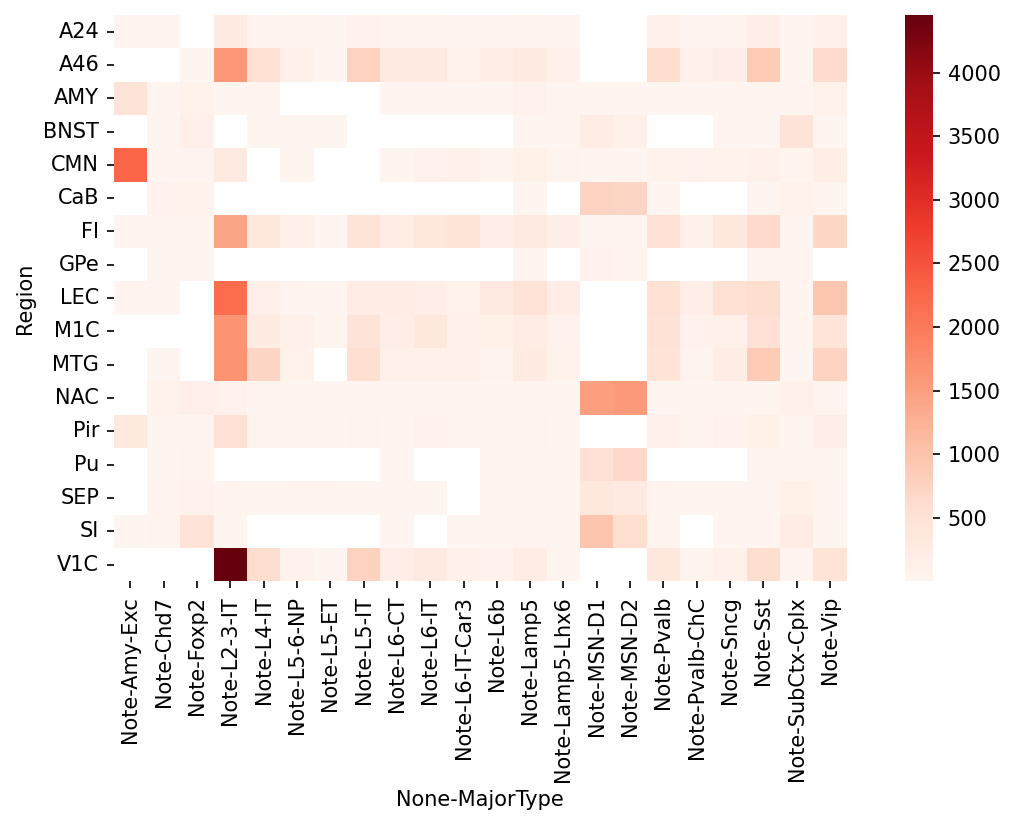

In [13]:
plt.figure(dpi=150, figsize=[10, 5])
sns.heatmap(
    table_s4_5\
        .loc[table_s4_5['Group'].isin(['EN', 'IN']), ['Region', 'MajorType', 'Note']]\
        .groupby(['Region', 'MajorType'])\
        .count()\
        .unstack(),#\
        # .loc[['A46', 'FI', 'LEC', 'MTG', 'M1C']],
    square=True,
    cmap='Reds'
)

In [76]:
table_s4_5['Group'].unique()

array(['ASC', 'IN', 'OPC', 'ODC', 'MGC', 'PC', 'VLMC', 'EC', 'EN'],
      dtype=object)

<AxesSubplot:xlabel='Region', ylabel='Group'>

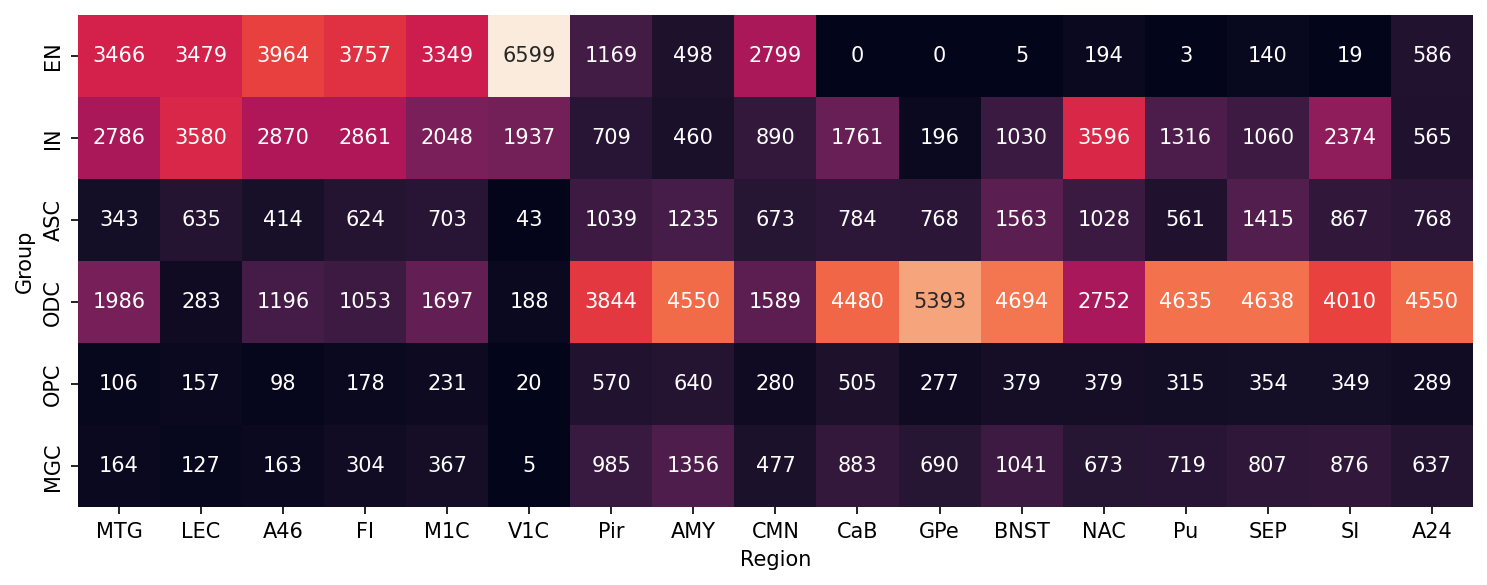

In [81]:
# Count number of cells per region per cell type
reg_order = ['MTG', 'LEC', 'A46', 'FI', 'M1C', 'V1C', 'Pir', 'AMY', 'CMN', 'CaB', 'GPe', 'BNST', 'NAC', 'Pu', 'SEP', 'SI', 'A24']
ct_order = ['EN', 'IN', 'ASC', 'ODC', 'OPC', 'MGC']
reg_ct_cnts = table_s4_5[['Region', 'Group', 'SubType']]\
    .groupby(['Region', 'Group'], as_index=False).count()\
    .pivot_table(index='Region', columns='Group').droplevel(0, axis=1).fillna(0).astype(int)\
    .loc[reg_order, ct_order].T

plt.figure(figsize=(12, 5), dpi=150)
sns.heatmap(reg_ct_cnts, square=True, annot=True, fmt='d', cbar=False)

In [ ]:
for ct in ['EN', 'IN']:
    subts = table_s4.loc[table_s4['CellClass'] == ct].index
    cell_names = list(table_s5.loc[table_s5['Region'].isin(regs) &
                                   table_s5['SubType'].isin(subts)].index)
    print(ct, len(cell_names))

In [14]:
for ct in table_s4['MajorType'].unique():
    subts = table_s4.loc[table_s4['MajorType'] == ct].index
    cell_names = list(table_s5.loc[table_s5['Region'].isin(regs) &
                                   table_s5['SubType'].isin(subts)].index)
    print(ct, len(cell_names))

CB 0
Chd7 1
Foxp2 0
Lamp5 278
Lamp5-Lhx6 97
MSN-D1 0
MSN-D2 0
PKJ 0
PN 0
Pvalb 499
Pvalb-ChC 54
Sncg 229
Sst 879
SubCtx-Cplx 4
THM-Exc 0
THM-Inh 0
THM-MB 0
Vip 745
ASC 343
EC 41
MGC 164
ODC 1986
OPC 106
PC 32
VLMC 72
Amy-Exc 0
CA1 0
CA3 0
DG 0
HIP-Misc1 0
HIP-Misc2 0
L2-3-IT 1655
L4-IT 722
L5-ET 0
L5-IT 587
L5-6-NP 91
L6-CT 117
L6-IT 128
L6-IT-Car3 107
L6b 59


In [17]:
for ct in table_s4['CellClass'].unique():
    subts = table_s4.loc[table_s4['CellClass'] == ct].index
    cell_names = list(table_s5.loc[table_s5['Region'].isin(regs) &
                                   table_s5['SubType'].isin(subts)].index)
    print(ct, len(cell_names))

IN 3580
NN 1785
EN 3479


In [18]:
for ct in ['EN', 'IN']:
    subts = table_s4.loc[table_s4['CellClass'] == ct].index
    cell_names = list(table_s5.loc[table_s5['Region'].isin(regs) &
                                   table_s5['SubType'].isin(subts)].index)
    print(ct, len(cell_names))

EN 3479
IN 3580


# Merge required "3C.contact" files into one

In [15]:
# Get required subtype ids
subts = table_s4.loc[table_s4['MajorType'].isin(cts) |
                     table_s4['CellClass'].isin(cts)].index

# Select cells with required brain region and cell subtype
if 'all' in cts:
    cell_names = list(table_s5.loc[table_s5['Region'].isin(regs)].index)
else:
    cell_names = list(table_s5.loc[table_s5['Region'].isin(regs) &
                                   table_s5['SubType'].isin(subts)].index)

print("Number of cells:", len(cell_names))
# print("First 5 cell names:", *cell_names[:5], sep='\n')

Number of cells: 14797


In [16]:
# Keep cells that were already downloaded
dwn_cellfn = listdir(pair_dir) # cell filename
dwn_celln = [
    re.sub('^GSM[0-9]*_|.3C.contact.tsv.gz$', '', fn) for fn in dwn_cellfn
] # cell name
dwn_dict = dict(zip(dwn_celln, dwn_cellfn)) # match cell "name" and "filename"

avail_cells = list(set(dwn_celln) & set(cell_names))
print("Number of available cells:", len(avail_cells), "out of", len(cell_names))

if (ncells != 0) & (ncells < len(avail_cells)): # limit number of cells
    avail_cells = np.random.choice(avail_cells, size=ncells, replace=False)

print("Using", len(avail_cells), "cells")

Number of available cells: 7852 out of 14797
Using 7852 cells


In [46]:
# Concatenate ".3C.contact.tsv.gz" files into one
# Might take several minutes

avail_fn = [dwn_dict[name] for name in avail_cells]
avail_fpath = [pair_dir + name for name in avail_fn]
pair_out_fn = "-".join(regs) + '.' + '-'.join(cts) + f".{int(len(avail_cells))}_cells" + '.3C.contact.tsv.gz'

# Save cell file names to a file
cell_lst_fp = '/tank/projects/tian2023/filelist.txt'
with open(cell_lst_fp, 'w') as fp:
    for fpath in avail_fpath:
        fp.write("%s\n" % fpath)
        
system(f"xargs cat < {cell_lst_fp} > {pair_out_fn}")

2

# Create cooler

In [14]:
# CLI command to create a cooler file
clr_out_fn = "-".join(regs) + '.' + '-'.join(cts) + f".{int(len(avail_cells))}_cells" + \
             f".{res // 1000}kb" + '.cool'
clr_exec_path = '/opt/anaconda/bin/cooler'
system(f"{clr_exec_path} cload pairs --assembly hg38 -c1 2 -p1 3 -c2 6 -p2 7 \
                {chrom_sizes}:{int(res)} {pair_out_fn} {clr_out_fn}")

# Work with cooler

In [3]:
res = 100_000

clr_path = {
    'EN': f"MTG.EN.3466_cells.10kb.mcool::resolutions/{res}",
    'IN': f"MTG.IN.2786_cells.10kb.mcool::resolutions/{res}",
}
cts = clr_path.keys()
clrs = {
    ct: cooler.Cooler(path) for ct, path in clr_path.items()
}
clrs

{'EN': <Cooler "MTG.EN.3466_cells.10kb.mcool::/resolutions/100000">,
 'IN': <Cooler "MTG.IN.2786_cells.10kb.mcool::/resolutions/100000">}

/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until


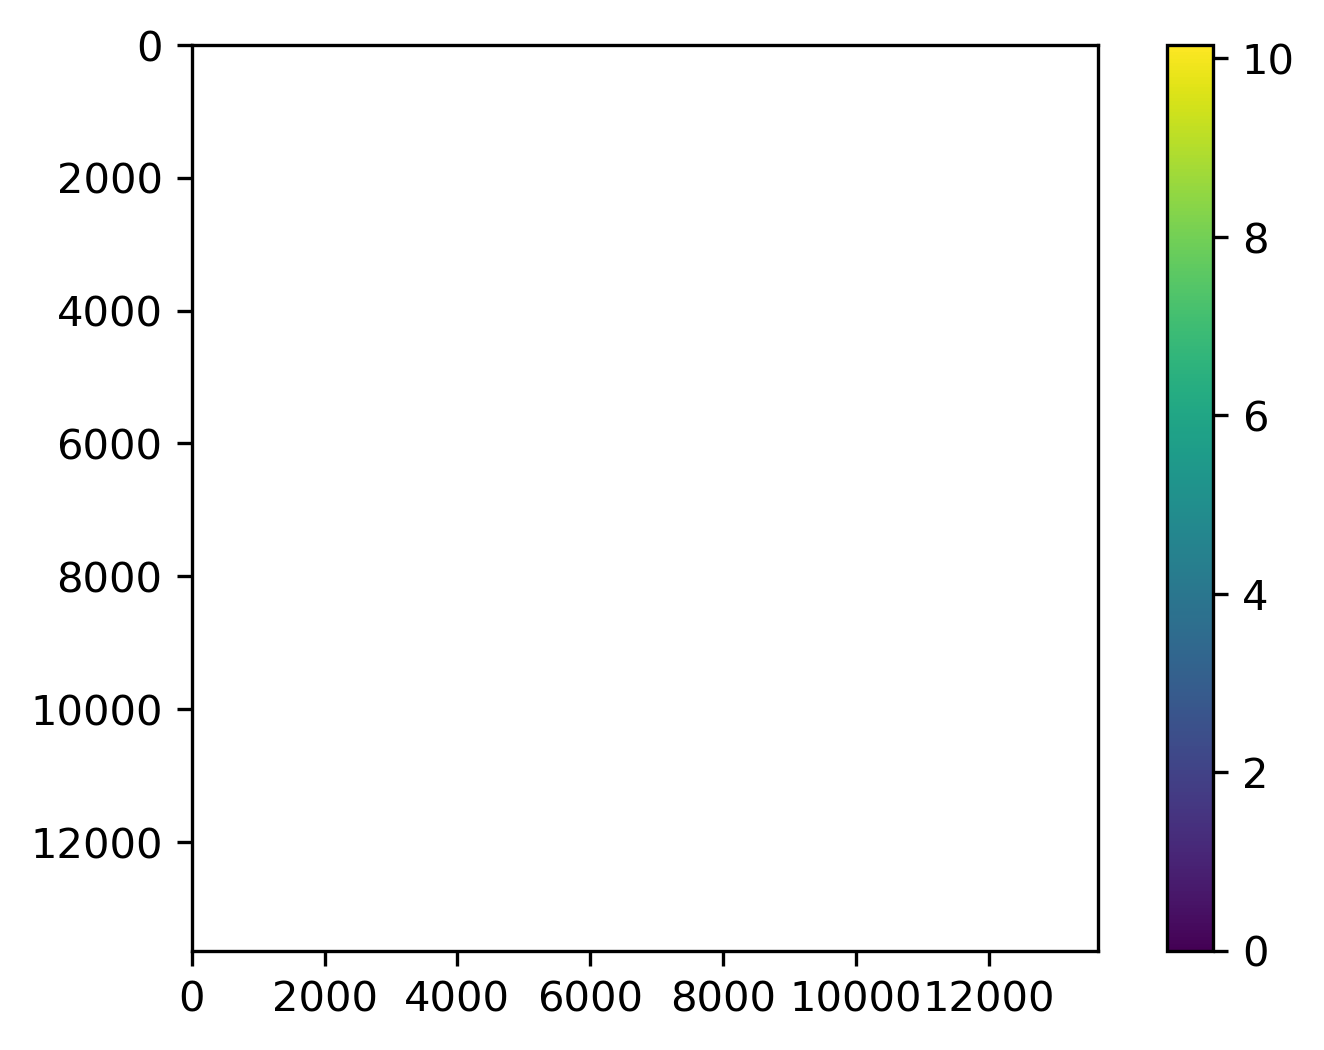

In [232]:
mtx = clr.matrix(balance=False).fetch('chr4:48,104,260-184,483,839')
plt.figure(dpi=300)
plt.imshow(np.log2(mtx))
plt.colorbar()

# Create script for making aggregated maps

In [9]:
don2age = {1: '42', 2: '29', 3: '58'}
table_s5['age'] = table_s5['Donor #'].map(don2age)
table_s5

,mCCCFrac,mCGFrac,mCHFrac,FinalmCReads,pool,Donor #,Region,tech,SubType,age
HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A1,0.0061,0.77,0.01,2120000.0,m3c16,2,BNST,m3C,93,29
HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A13,0.0049,0.77,0.01,2250000.0,m3c16,2,BNST,m3C,20,29
HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A14,0.0052,0.75,0.01,2660000.0,m3c16,2,BNST,m3C,104,29
HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A2,0.0088,0.75,0.01,2370000.0,m3c16,2,BNST,m3C,101,29
HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-B1,0.0051,0.76,0.02,780000.0,m3c16,2,BNST,m3C,98,29
...,...,...,...,...,...,...,...,...,...,...
HBA_211117_H1930002_CX47_FI_3C_1_P8-6-J7-O24,0.0108,0.80,0.05,1950000.0,m3c11,2,FI,m3C,50,29
HBA_211117_H1930002_CX47_FI_3C_1_P8-6-J7-P11,0.0129,0.77,0.06,2450000.0,m3c11,2,FI,m3C,179,29
HBA_211117_H1930002_CX47_FI_3C_1_P8-6-J7-P12,0.0067,0.80,0.03,2910000.0,m3c11,2,FI,m3C,88,29
HBA_211117_H1930002_CX47_FI_3C_1_P8-6-J7-P23,0.0082,0.79,0.04,2290000.0,m3c11,2,FI,m3C,49,29


In [7]:
%%writefile make_clr_sub.py

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from os import listdir, path
import os
import sys
import logging
import subprocess
import re
import argparse
# from time import sleep

# Set argparse
parser = argparse.ArgumentParser(description="Make cooler matrices from single-cell contact pair files.")

parser.add_argument('-r', '--regs', help='Comma-delimited list of regions to merge; type "all" to select all regions.', 
                    type=str, required=True)
parser.add_argument('-c', '--cts', help='Comma-delimited list of cell-types to merge. Can be "MajorType" or "CellClass" names', 
                    type=str, required=True)
parser.add_argument('-a', '--ages', help='Comma-delimited list of ages to merge. Ages available: 29, 42, and 58', 
                    type=str, default="29,42,58")
parser.add_argument('-bs', '--binsize', help='Smallest binsize for the resulting cooler', 
                    type=int, required=True)
parser.add_argument('-n', '--ncells', help='Limit number of used cells to <ncells> sampled randomly', 
                    type=int, default=0)
parser.add_argument('-nz', '--no-zoomify', 
                    help="Don't make .mcool out of .cool", 
                    default=False, action='store_true')
parser.add_argument('-hg', '--higlass', 
                    help='Whether to upload a map to HiGlass to "Tian et al. 2023" project', 
                    default=False, action='store_true')

args = parser.parse_args()

regs = args.regs.split(',')
cts = args.cts.split(',')
ages = args.ages.split(',')
res = args.binsize
ncells = args.ncells
no_zoomify = args.no_zoomify
upload2higlass = args.higlass

# 3) Path to Suppl. Tables from Tian2023
table_s4_path = "/tank/projects/tian2023/table-S4-cell-type-taxonomy.tsv.gz"
table_s5_path = "/tank/projects/tian2023/table-S5-meta.csv.gz"

# 4) Path to directory with downloaded pair files
pair_dir = "/tank/projects/tian2023/contacts/"

# 6) Path to file with chromosome sizes
chrom_sizes = '/tank/projects/tian2023/hg38.reduced.chrom.sizes'

# Set up logs
log_fname = 'mcools_logs/' + "_".join(regs) + '.' + '_'.join(cts) + '.' + '_'.join(ages) + \
            '_years' + f".{ncells}_cells" + ".log"
file_handler = logging.FileHandler(filename=log_fname, mode='w')
stdout_handler = logging.StreamHandler(stream=sys.stdout)
handlers = [file_handler, stdout_handler]
logging.basicConfig(level=logging.DEBUG, 
                    format='%(asctime)s - %(levelname)s - %(message)s', 
                    datefmt='%Y-%m-%d %H:%M:%S',
                    handlers=handlers,)
logging.info(f"logs are saved to {log_fname}")

def uniquify(path):
    """
    Make unique filepath by adding an integer suffix.
    Borrowed from: https://stackoverflow.com/questions/13852700/create-file-but-if-name-exists-add-number
    """
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + "-" + str(counter) + extension
        counter += 1

    return path


def run_and_log(cmd, **kwargs):
    process = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        **kwargs,
    )
    while True:
        line = process.stdout.readline()
        if not line and process.poll() is not None:
            logging.debug(f"Return code: {process.returncode}")
            break
        elif line != '':
            logging.info(line.decode().strip())
        else:
            continue


def make_clr(regs, 
             cts, 
             ages, 
             clr_minres, 
             pair_dir=pair_dir,
             chrom_sizes=chrom_sizes,
             table_s4_path=table_s4_path,
             table_s5_path = table_s5_path,
             no_zoomify=False,
             zoomify_nproc=5, 
             upload2higlass=False,
             clr_exec_path='/opt/anaconda/bin/cooler'):
    
    # Read table s4 with subtype description
    table_s4 = pd.read_table(table_s4_path, index_col=0)
    table_s4['CellClass'] = table_s4['CellClass'].map({
        "Inhibitory/non-telencephalic neurons": 'IN',
        "Telencephalic excitatory neurons": 'EN',
        "Non-neuronal Cells": 'NN'
    })
    
    # Load metadata table
    table_s5 = pd.read_table(table_s5_path, index_col=0, sep=',')
    table_s5 = table_s5.loc[table_s5['tech'] == 'm3C']
    don2age = {1: '42', 2: '29', 3: '58'}
    table_s5['age'] = table_s5['Donor #'].map(don2age)
    
    # Get required subtype ids
    subts = table_s4.loc[table_s4['MajorType'].isin(cts) |
                         table_s4['CellClass'].isin(cts)].index

    # Check that specified regions, cell types and ages exist
    assert (len(subts) > 0), "Wrong cell types specified."
    logging.info(f"Subtype ids: {list(subts)}")

    if 'all' in regs:
        logging.info("Using all regions")
    else:
        avail_regs = table_s5.loc[table_s5['Region'].isin(regs), 'Region'].unique()
        assert (len(avail_regs) > 0), "Wrong regions specified."
        logging.info(f"Available regions: {list(avail_regs)}")

    avail_ages = table_s5.loc[table_s5['age'].isin(ages), 'age'].unique()
    assert (len(avail_ages) > 0), "Wrong ages specified."
    logging.info(f"Available ages: {list(ages)}")

    # Select cells with required brain region, cell subtype and age
    if 'all' in regs:
        cell_names = list(table_s5.loc[table_s5['SubType'].isin(subts) & 
                                       table_s5['age'].isin(ages)].index)
    else:
        cell_names = list(table_s5.loc[table_s5['Region'].isin(regs) &
                                       table_s5['SubType'].isin(subts) & 
                                       table_s5['age'].isin(ages)].index)
    logging.info(f"Number of cells: {len(cell_names)}")
    
    # Keep cells that were already downloaded
    dwn_cellfn = os.listdir(pair_dir) # cell filename
    dwn_celln = [
        re.sub('^GSM[0-9]*_|.3C.contact.tsv.gz$', '', fn) for fn in dwn_cellfn
    ] # cell name
    dwn_dict = dict(zip(dwn_celln, dwn_cellfn)) # match cell "name" and "filename"

    avail_cells = list(set(dwn_celln) & set(cell_names))
    logging.info(f"Number of available cells: {len(avail_cells)} out of {len(cell_names)}")

    if (ncells != 0) & (ncells < len(avail_cells)): # limit number of cells
        np.random.seed(0)
        avail_cells = np.random.choice(avail_cells, size=ncells, replace=False)

    logging.info(f"Using {len(avail_cells)} cells")
    logging.info(f"First 10 cells used: {table_s5.loc[avail_cells[:10]]} \n")
    logging.info(f"Brain regions used: {table_s5.loc[avail_cells, 'Region'].unique()}")
    logging.info(f"Cell subtypes used: {table_s5.loc[avail_cells, 'SubType'].unique()}")
    logging.info(f"Ages used: {table_s5.loc[avail_cells, 'age'].unique()}")

    avail_fn = [dwn_dict[name] for name in avail_cells]
    avail_fpath = [pair_dir + name for name in avail_fn]

    # Save cell file names to a file
    fname_prefix = "_".join(regs) + '.' + '_'.join(cts) + '.' + '_'.join(ages) + \
                   '_years' + f".{int(len(avail_cells))}_cells"
    cell_lst_fp = "tmp." + fname_prefix + ".filelist.txt"
    
    if os.path.exists(cell_lst_fp):
        logging.warning(
            "Filename for temporary storing list of filenames for contact files already exists. " + \
            "Creating a unique filename.."
        )
        cell_lst_fp = uniquify(cell_lst_fp)
        
    with open(cell_lst_fp, 'w') as fp:
        for fpath in avail_fpath:
            fp.write("%s\n" % fpath)

    # Concatenate ".3C.contact.tsv.gz" files into one
    # Might take several minutes
    pair_out_fn = fname_prefix + '.3C.contact.tsv.gz'
    
    if os.path.exists(pair_out_fn):
        logging.warning(
            "Filename for temporary storing merged contact files already exists. " + \
            "Creating a unique filename.."
        )
        pair_out_fn = uniquify(pair_out_fn)

    logging.info("Concatenating '.3C.contact.tsv.gz' files for individual cells into one, " + \
                 "might take several minutes..")
    os.system(f"xargs cat < {cell_lst_fp} > {pair_out_fn}")
    run_and_log(['rm', cell_lst_fp]) # UNCOMMENT LATER
    
    # CLI command to create a cooler file
    clr_out_fn = fname_prefix + f".{clr_minres // 1000}kb" + '.cool'
    
    if os.path.exists(clr_out_fn):
        logging.warning("Cooler with this filename already exists, overwriting..")
        run_and_log(['rm', clr_out_fn])

    logging.info('Creating cooler..')
    cload_cmd = [clr_exec_path, 'cload', 'pairs', '--assembly', 'hg38', 
                 '-c1', '2', '-p1', '3', '-c2', '6', '-p2', '7', f'{chrom_sizes}:{int(clr_minres)}',
                 '--chunksize', '150000000', pair_out_fn, clr_out_fn]
    run_and_log(cload_cmd)
    
    if not os.path.exists(clr_out_fn):
        logging.error("For some reason, cooler file has not been created.")
        raise ValueError("For some reason, cooler file has not been created.")

    logging.info("Cooler has been created.")
    run_and_log(['rm', pair_out_fn])
    
    # balance and zoomify cooler
    if no_zoomify:
        logging.info("THE SCRIPT HAS COMPLETED SUCCESSFULLY.")
        return
    else:
        logging.info("Zoomifying and balancing cooler..")
        zoom_cmd = [clr_exec_path, 'zoomify', '-p', str(zoomify_nproc), '-r', str(clr_minres)+'N',
                    '--chunksize', '100000000', '--balance', clr_out_fn]
        run_and_log(zoom_cmd)
        mcool_fn = re.sub(".cool$", ".mcool", clr_out_fn)
        
        if not os.path.exists(mcool_fn):
            logging.error("For some reason, .mcool file has not been created.")
            raise ValueError("For some reason, .mcool file has not been created.")

        logging.info(".mcool file has been created, removing .cool..")
        run_and_log(['rm', clr_out_fn])
        
    # else:
    #     logging.info("Balancing cooler..")
    #     run_and_log([clr_exec_path, 'balance', clr_out_fn])
    
        # upload2higlass
        if upload2higlass:
            logging.info(".mcool file has not been created since") 
            logging.info("Uploading to HiGlass..")
            run_and_log(['cp', mcool_fn, f"/tank/hg-tmp/{mcool_fn}"])
            higlass_cmd = ['docker', 'exec', 'higlass-container', 'python', 
                           'higlass-server/manage.py', 'ingest_tileset', 
                           '--filename', f'/tmp/{mcool_fn}', 
                           '--filetype', 'cooler',
                           '--datatype', 'matrix',
                           '--coordSystem', 'hg38',
                           '--name', mcool_fn,
                           '--project', "Tian et al. 2023"]
            run_and_log(higlass_cmd)
            run_and_log(['rm', f'/tank/hg-tmp/{mcool_fn}'])
    
        logging.info("THE SCRIPT HAS COMPLETED SUCCESSFULLY.")
        
    return


# MAIN
make_clr(regs, cts, ages, res, no_zoomify=no_zoomify, upload2higlass=upload2higlass)

Overwriting make_clr_sub.py


# Make bulk matrix from coolers of individual cells

## Find necessary cells

In [54]:
regs = ['MTG']
cts = ['EN', 'ODC']
ages = ['29']
ncells = 100
res = 10_000

In [55]:
table_s4_path = "/tank/projects/tian2023/table-S4-cell-type-taxonomy.tsv.gz"
table_s5_path = "/tank/projects/tian2023/table-S5-meta.csv.gz"
clr_dir = "/tank/projects/tian2023/cools/"
pair_dir = "/tank/projects/tian2023/contacts/"
chrom_sizes = '/tank/projects/tian2023/hg38.reduced.chrom.sizes'
clr_exec_path='/opt/anaconda/bin/cooler'

In [56]:
# Read table s4 with subtype description
table_s4 = pd.read_table(table_s4_path, index_col=0)
table_s4['CellClass'] = table_s4['CellClass'].map({
    "Inhibitory/non-telencephalic neurons": 'IN',
    "Telencephalic excitatory neurons": 'EN',
    "Non-neuronal Cells": 'NN'
})

In [57]:
# Load metadata table
import os
import sys

table_s5 = pd.read_table(table_s5_path, index_col=0, sep=',')
table_s5 = table_s5.loc[table_s5['tech'] == 'm3C']
don2age = {1: '42', 2: '29', 3: '58'}
table_s5['age'] = table_s5['Donor #'].map(don2age)

# Get required subtype ids
subts = table_s4.loc[table_s4['MajorType'].isin(cts) |
                     table_s4['CellClass'].isin(cts)].index

# Check that specified regions, cell types and ages exist
assert (len(subts) > 0), "Wrong cell types specified."

avail_regs = table_s5.loc[table_s5['Region'].isin(regs), 'Region'].unique()
assert (len(avail_regs) > 0), "Wrong regions specified."

avail_ages = table_s5.loc[table_s5['age'].isin(ages), 'age'].unique()
assert (len(avail_ages) > 0), "Wrong ages specified."

# Select cells with required brain region, cell subtype and age
cell_names = list(table_s5.loc[table_s5['Region'].isin(regs) &
                               table_s5['SubType'].isin(subts) & 
                               table_s5['age'].isin(ages)].index)

# Keep cells that were already downloaded
dwn_cellfn = os.listdir(clr_dir) # cell filename
dwn_celln = [
    re.sub('^GSM[0-9]*_|.cool$', '', fn) for fn in dwn_cellfn
] # cell name
dwn_dict = dict(zip(dwn_celln, dwn_cellfn)) # match cell "name" and "filename"

avail_cells = list(set(dwn_celln) & set(cell_names))
avail_cells[:10]

/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


['HBA_211130_H1930002_CX52_MTG_3C_1_P8-4-J7-P20',
 'HBA_211130_H1930002_CX52_MTG_3C_1_P3-1-K20-O14',
 'HBA_211130_H1930002_CX52_MTG_3C_1_P7-6-L3-K24',
 'HBA_211130_H1930002_CX52_MTG_3C_1_P2-6-K18-N24',
 'HBA_211130_H1930002_CX52_MTG_3C_1_P5-5-I24-G22',
 'HBA_211130_H1930002_CX52_MTG_3C_1_P5-3-I24-M18',
 'HBA_211130_H1930002_CX52_MTG_3C_1_P2-3-K18-L6',
 'HBA_211130_H1930002_CX52_MTG_3C_1_P2-2-K18-L4',
 'HBA_211130_H1930002_CX52_MTG_3C_1_P6-6-J3-M23',
 'HBA_211130_H1930002_CX52_MTG_3C_1_P3-3-K20-A6']

In [58]:
if (ncells != 0) & (ncells < len(avail_cells)): # limit number of cells
    np.random.seed(0)
    avail_cells = np.random.choice(avail_cells, size=ncells, replace=False)

In [59]:
sel_cells = [dwn_dict[cname] for cname in avail_cells]
sel_cells[:5]

['GSM6803560_HBA_211130_H1930002_CX52_MTG_3C_1_P5-4-I24-B7.cool',
 'GSM6802556_HBA_211130_H1930002_CX52_MTG_3C_1_P2-6-K18-D12.cool',
 'GSM6803196_HBA_211130_H1930002_CX52_MTG_3C_1_P4-4-E22-F8.cool',
 'GSM6804007_HBA_211130_H1930002_CX52_MTG_3C_1_P6-4-J3-L19.cool',
 'GSM6803681_HBA_211130_H1930002_CX52_MTG_3C_1_P5-5-I24-N10.cool']

## Merge from coolers

In [60]:
%%timeit
bulk_out = "/tank/projects/tian2023/merged_bulk_from_cools.cool"
input_paths = [clr_dir + cname for cname in sel_cells]
input_paths[:5]
cooler.merge_coolers(bulk_out, input_paths, mergebuf=100000000)

1min 1s ± 16.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Merge from pairs

In [61]:
import subprocess


def uniquify(path):
    """
    Make unique filepath by adding an integer suffix.
    Borrowed from: https://stackoverflow.com/questions/13852700/create-file-but-if-name-exists-add-number
    """
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + "-" + str(counter) + extension
        counter += 1

    return path


def run_and_log(cmd, **kwargs):
    process = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        **kwargs,
    )
    while True:
        line = process.stdout.readline()
        if not line and process.poll() is not None:
            # logging.debug(f"Return code: {process.returncode}")
            break
        else:
            continue
    

# Keep cells that were already downloaded
dwn_cellfn = os.listdir(pair_dir) # cell filename
dwn_celln = [
    re.sub('^GSM[0-9]*_|.3C.contact.tsv.gz$', '', fn) for fn in dwn_cellfn
] # cell name
dwn_dict = dict(zip(dwn_celln, dwn_cellfn)) # match cell "name" and "filename"

avail_cells = list(set(dwn_celln) & set(cell_names))

if (ncells != 0) & (ncells < len(avail_cells)): # limit number of cells
    np.random.seed(0)
    avail_cells = np.random.choice(avail_cells, size=ncells, replace=False)
        
avail_fn = [dwn_dict[name] for name in avail_cells]
avail_fpath = [pair_dir + name for name in avail_fn]

# Save cell file names to a file
fname_prefix = "_".join(regs) + '.' + '_'.join(cts) + '.' + '_'.join(ages) + \
               '_years' + f".{int(len(avail_cells))}_cells"
cell_lst_fp = "tmp." + fname_prefix + ".filelist.txt"

if os.path.exists(cell_lst_fp):
    # logging.warning(
    #     "Filename for temporary storing list of filenames for contact files already exists. " + \
    #     "Creating a unique filename.."
    # )
    cell_lst_fp = uniquify(cell_lst_fp)
    
with open(cell_lst_fp, 'w') as fp:
    for fpath in avail_fpath:
        fp.write("%s\n" % fpath)

# Concatenate ".3C.contact.tsv.gz" files into one
# Might take several minutes
pair_out_fn = fname_prefix + '.3C.contact.tsv.gz'

if os.path.exists(pair_out_fn):
    # logging.warning(
    #     "Filename for temporary storing merged contact files already exists. " + \
    #     "Creating a unique filename.."
    # )
    pair_out_fn = uniquify(pair_out_fn)

In [62]:
%%timeit

# CLI command to create a cooler file
os.system(f"xargs cat < {cell_lst_fp} > {pair_out_fn}")

clr_out_fn = fname_prefix + f".{res // 1000}kb" + '.cool'

if os.path.exists(clr_out_fn):
    print("Cooler with this filename already exists, overwriting..")
    run_and_log(['rm', clr_out_fn])

# logging.info('Creating cooler..')
cload_cmd = [clr_exec_path, 'cload', 'pairs', '--assembly', 'hg38', 
             '-c1', '2', '-p1', '3', '-c2', '6', '-p2', '7', f'{chrom_sizes}:{int(res)}',
             '--chunksize', '150000000', pair_out_fn, clr_out_fn]
run_and_log(cload_cmd)
run_and_log(['rm', pair_out_fn])

Cooler with this filename already exists, overwriting..
Cooler with this filename already exists, overwriting..
Cooler with this filename already exists, overwriting..
Cooler with this filename already exists, overwriting..
Cooler with this filename already exists, overwriting..
Cooler with this filename already exists, overwriting..
Cooler with this filename already exists, overwriting..
2min 19s ± 8.49 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
mcool_out = bulk_out.rstrip(".cool") + ".mcool"
zoom_res_list = {
    10_000: [10000, 100000, 1000000, 10000000, 20000, 200000, 2000000,
             50000, 500000, 5000000]
}
cooler.zoomify_cooler(bulk_out, mcool_out, zoom_res_list[res], chunksize=100000000, nproc=5)

/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooler/util.py:733: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  is_cat = pd.api.types.is_categorical(bins["chrom"])
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooler/util.py:733: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  is_cat = pd.api.types.is_categorical(bins["chrom"])
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooler/util.py:733: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  is_cat = pd.api.types.is_categorical(bins["chrom"])
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooler/util.py:733: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  is_cat = pd.api.types.is_categorical(bin

# Preparing data for 3C trajectories

## Tian

In [2]:
table_s4_path = "/tank/projects/tian2023/table-S4-cell-type-taxonomy.tsv.gz"
table_s5_path = "/tank/projects/tian2023/table-S5-meta.csv.gz"

In [3]:
s5 = pd.read_table(table_s5_path, sep=',')\
    .rename(columns={"SubType": 'SubType_id', "Unnamed: 0": 'cell_id'})\
    .query("tech == 'm3C'")
s5.head()

/tmp/ipykernel_1834445/3195128165.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  s5 = pd.read_table(table_s5_path, sep=',')\


,cell_id,mCCCFrac,mCGFrac,mCHFrac,FinalmCReads,pool,Donor #,Region,tech,SubType_id
0,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A1,0.0061,0.77,0.01,2120000.0,m3c16,2,BNST,m3C,93.0
1,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A13,0.0049,0.77,0.01,2250000.0,m3c16,2,BNST,m3C,20.0
2,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A14,0.0052,0.75,0.01,2660000.0,m3c16,2,BNST,m3C,104.0
3,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A2,0.0088,0.75,0.01,2370000.0,m3c16,2,BNST,m3C,101.0
4,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-B1,0.0051,0.76,0.02,780000.0,m3c16,2,BNST,m3C,98.0


In [4]:
s4 = pd.read_table(table_s4_path)\
    .rename(columns={"Unnamed: 0": 'SubType_id'})
s4.head()

,SubType_id,SubType,MajorType,CellClass,Note
0,1,CB_0,CB,Inhibitory/non-telencephalic neurons,Granule cells from cerebellum
1,2,CB_1,CB,Inhibitory/non-telencephalic neurons,Granule cells from cerebellum
2,3,CB_2,CB,Inhibitory/non-telencephalic neurons,Granule cells from cerebellum
3,4,CHD7_0,Chd7,Inhibitory/non-telencephalic neurons,Neurons from BF/BN with gene CHD7 hypomethylated
4,5,CHD7_1,Chd7,Inhibitory/non-telencephalic neurons,Neurons from BF/BN with gene CHD7 hypomethylated


In [5]:
s4_5 = s5.merge(s4, how='left', on='SubType_id')
s4_5.head()

,cell_id,mCCCFrac,mCGFrac,mCHFrac,FinalmCReads,pool,Donor #,Region,tech,SubType_id,SubType,MajorType,CellClass,Note
0,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A1,0.0061,0.77,0.01,2120000.0,m3c16,2,BNST,m3C,93.0,ASC_0,ASC,Non-neuronal Cells,Astrocytes
1,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A13,0.0049,0.77,0.01,2250000.0,m3c16,2,BNST,m3C,20.0,MSN_D1_0,MSN-D1,Inhibitory/non-telencephalic neurons,D1 type medium spiny neurons
2,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A14,0.0052,0.75,0.01,2660000.0,m3c16,2,BNST,m3C,104.0,OPC_0,OPC,Non-neuronal Cells,Oligodendrocyte progenitor cell
3,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A2,0.0088,0.75,0.01,2370000.0,m3c16,2,BNST,m3C,101.0,ODC_0,ODC,Non-neuronal Cells,Oligodendrocytes
4,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-B1,0.0051,0.76,0.02,780000.0,m3c16,2,BNST,m3C,98.0,Bergmann-glia,ASC,Non-neuronal Cells,Astrocytes


In [6]:
s4.loc[s4['CellClass'] == 'Non-neuronal Cells']

,SubType_id,SubType,MajorType,CellClass,Note
92,93,ASC_0,ASC,Non-neuronal Cells,Astrocytes
93,94,ASC_1,ASC,Non-neuronal Cells,Astrocytes
94,95,ASC_2,ASC,Non-neuronal Cells,Astrocytes
95,96,ASC_3,ASC,Non-neuronal Cells,Astrocytes
96,97,ASC_4,ASC,Non-neuronal Cells,Astrocytes
97,98,Bergmann-glia,ASC,Non-neuronal Cells,Astrocytes
98,99,EC_0,EC,Non-neuronal Cells,Endothelial cell
99,100,MGC_0,MGC,Non-neuronal Cells,Macro glia
100,101,ODC_0,ODC,Non-neuronal Cells,Oligodendrocytes
101,102,ODC_1,ODC,Non-neuronal Cells,Oligodendrocytes


In [7]:
s4_5['MajorType'].unique()

array(['ASC', 'MSN-D1', 'OPC', 'ODC', 'Foxp2', 'MGC', 'SubCtx-Cplx', 'PC',
       'VLMC', 'MSN-D2', 'Sst', 'EC', 'Chd7', 'Vip', 'Lamp5',
       'Lamp5-Lhx6', 'L6-IT-Car3', 'Amy-Exc', 'L6b', 'L6-CT', 'Pvalb-ChC',
       'Pvalb', 'Sncg', 'L6-IT', 'L4-IT', 'L5-IT', 'L2-3-IT', 'L5-6-NP',
       'L5-ET'], dtype=object)

In [8]:
# Add filenames to table

# coolers
clr_dir = "/tank/projects/tian2023/cools/"
clr_cellfn = listdir(clr_dir) # cell filename
clr_celln = [
    re.sub('^GSM[0-9]*_|.cool$', '', fn) for fn in clr_cellfn
] # cell name
clr_dict = dict(zip(clr_celln, clr_cellfn)) # match cell "name" and "filename"

# Contacts
pair_dir = "/tank/projects/tian2023/contacts/"
dwn_cellfn = listdir(pair_dir) # cell filename
dwn_celln = [
    re.sub('^GSM[0-9]*_|.3C.contact.tsv.gz$', '', fn) for fn in dwn_cellfn
] # cell name
dwn_dict = dict(zip(dwn_celln, dwn_cellfn)) # match cell "name" and "filename"
s4_5['contacts_fname'] = s4_5['cell_id'].map(dwn_dict)
s4_5.dropna(inplace=True)

s4_5['contacts_fpath'] = pair_dir + s4_5['contacts_fname']

s4_5.head()

,cell_id,mCCCFrac,mCGFrac,mCHFrac,FinalmCReads,pool,Donor #,Region,tech,SubType_id,SubType,MajorType,CellClass,Note,contacts_fname,contacts_fpath
0,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A1,0.0061,0.77,0.01,2120000.0,m3c16,2,BNST,m3C,93.0,ASC_0,ASC,Non-neuronal Cells,Astrocytes,GSM6825696_HBA_220218_H1930002_CX47_BNST_3C_1_...,/tank/projects/tian2023/contacts/GSM6825696_HB...
1,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A13,0.0049,0.77,0.01,2250000.0,m3c16,2,BNST,m3C,20.0,MSN_D1_0,MSN-D1,Inhibitory/non-telencephalic neurons,D1 type medium spiny neurons,GSM6825697_HBA_220218_H1930002_CX47_BNST_3C_1_...,/tank/projects/tian2023/contacts/GSM6825697_HB...
2,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A14,0.0052,0.75,0.01,2660000.0,m3c16,2,BNST,m3C,104.0,OPC_0,OPC,Non-neuronal Cells,Oligodendrocyte progenitor cell,GSM6825698_HBA_220218_H1930002_CX47_BNST_3C_1_...,/tank/projects/tian2023/contacts/GSM6825698_HB...
3,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A2,0.0088,0.75,0.01,2370000.0,m3c16,2,BNST,m3C,101.0,ODC_0,ODC,Non-neuronal Cells,Oligodendrocytes,GSM6825699_HBA_220218_H1930002_CX47_BNST_3C_1_...,/tank/projects/tian2023/contacts/GSM6825699_HB...
4,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-B1,0.0051,0.76,0.02,780000.0,m3c16,2,BNST,m3C,98.0,Bergmann-glia,ASC,Non-neuronal Cells,Astrocytes,GSM6825700_HBA_220218_H1930002_CX47_BNST_3C_1_...,/tank/projects/tian2023/contacts/GSM6825700_HB...


In [9]:
s4_5.loc[0, 'contacts_fpath']

'/tank/projects/tian2023/contacts/GSM6825696_HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A1.3C.contact.tsv.gz'

In [7]:
# Missing interneurons 
inter_cts = ['Lamp5', 'Lamp5-Lhx6', 'Pvalb', 'Pvalb-ChC', 'Sncg', 'Sst', 'Vip']
s_miss = s4_5.loc[s4_5['MajorType'].isin(inter_cts) & ~s4_5['cell_id'].isin(clr_celln)].reset_index(drop=True)
s_miss.head()

,cell_id,mCCCFrac,mCGFrac,mCHFrac,FinalmCReads,pool,Donor #,Region,tech,SubType_id,SubType,MajorType,CellClass,Note,contacts_fname


In [76]:
# save to file
s_miss[['contacts_fname']].to_csv("missing_coolers.txt", sep='\t', index=False, header=False)

In [8]:
s_miss.shape

(0, 15)

In [59]:
s_miss.loc[0, 'contacts_fname']

'GSM6826531_HBA_220218_H1930002_CX47_BNST_3C_1_P3-1-K20-B13.3C.contact.tsv.gz'

In [71]:
%%writefile make_missing_clrs.sh
CHROM_SIZES="/tank/projects/tian2023/hg38.reduced.chrom.sizes"
CONTACT_DIR="/tank/projects/tian2023/contacts/"
CLR_DIR="/tank/projects/tian2023/cools/"
MISS_LIST="/tank/projects/tian2023/missing_coolers.txt"

COUNT=0
while read CONTACT_FNAME
do
    echo ${CONTACT_FNAME}
    echo ${COUNT}
    CLR_FNAME="${CONTACT_FNAME%.3C.contact.tsv.gz}.cool"
    cooler cload pairs --assembly hg38 -c1 2 -p1 3 -c2 6 -p2 7 "${CHROM_SIZES}:10000" \
        --chunksize 150000000 \
        "${CONTACT_DIR}${CONTACT_FNAME}" \
        "${CLR_DIR}${CLR_FNAME}"
    COUNT=COUNT+1
done < ${MISS_LIST}

Overwriting make_missing_clrs.sh


In [10]:
# Metadata for interneurons
inter_cts = ['Lamp5', 'Lamp5-Lhx6', 'Pvalb', 'Pvalb-ChC', 'Sncg', 'Sst', 'Vip']
ctx_regs = ['Pir', 'MTG', 'A24', 'A46', 'M1C', 'FI', 'V1C', 'LEC']
s_inter = s4_5.loc[s4_5['MajorType'].isin(inter_cts) & 
                   s4_5['Region'].isin(ctx_regs) &
                   s4_5['cell_id'].isin(clr_celln)].reset_index(drop=True)
s_inter['cooler_fname'] = s_inter['contacts_fname'].str.replace('.3C.contact.tsv.gz$', '.cool', regex=True)
s_inter

,cell_id,mCCCFrac,mCGFrac,mCHFrac,FinalmCReads,pool,Donor #,Region,tech,SubType_id,SubType,MajorType,CellClass,Note,contacts_fname,contacts_fpath,cooler_fname
0,HBA_220608_H1930004_CX45_Pir_3C_1_P1-1-M14-A2,0.0136,0.79,0.06,1680000.0,m3c47,3,Pir,m3C,59.0,Sst_5,Sst,Inhibitory/non-telencephalic neurons,Cortical inhibitory neurons with genes Sst hyp...,GSM7333306_HBA_220608_H1930004_CX45_Pir_3C_1_P...,/tank/projects/tian2023/contacts/GSM7333306_HB...,GSM7333306_HBA_220608_H1930004_CX45_Pir_3C_1_P...
1,HBA_220608_H1930004_CX45_Pir_3C_1_P1-1-M14-N13,0.0166,0.79,0.07,2290000.0,m3c47,3,Pir,m3C,46.0,Pvalb_ChC_0,Pvalb-ChC,Inhibitory/non-telencephalic neurons,Chandelier cells,GSM7333354_HBA_220608_H1930004_CX45_Pir_3C_1_P...,/tank/projects/tian2023/contacts/GSM7333354_HB...,GSM7333354_HBA_220608_H1930004_CX45_Pir_3C_1_P...
2,HBA_220608_H1930004_CX45_Pir_3C_1_P1-1-M14-O14,0.0136,0.80,0.06,752000.0,m3c47,3,Pir,m3C,88.0,Vip_4,Vip,Inhibitory/non-telencephalic neurons,Cortical inhibitory neurons with genes Vip hyp...,GSM7333358_HBA_220608_H1930004_CX45_Pir_3C_1_P...,/tank/projects/tian2023/contacts/GSM7333358_HB...,GSM7333358_HBA_220608_H1930004_CX45_Pir_3C_1_P...
3,HBA_220608_H1930004_CX45_Pir_3C_1_P1-2-M14-E16,0.0148,0.81,0.07,2080000.0,m3c47,3,Pir,m3C,54.0,Sst_0,Sst,Inhibitory/non-telencephalic neurons,Cortical inhibitory neurons with genes Sst hyp...,GSM7333378_HBA_220608_H1930004_CX45_Pir_3C_1_P...,/tank/projects/tian2023/contacts/GSM7333378_HB...,GSM7333378_HBA_220608_H1930004_CX45_Pir_3C_1_P...
4,HBA_220608_H1930004_CX45_Pir_3C_1_P1-2-M14-F16,0.0111,0.81,0.05,2380000.0,m3c47,3,Pir,m3C,50.0,Sncg_1,Sncg,Inhibitory/non-telencephalic neurons,"Cortical inhibitory neurons, homologous cell t...",GSM7333382_HBA_220608_H1930004_CX45_Pir_3C_1_P...,/tank/projects/tian2023/contacts/GSM7333382_HB...,GSM7333382_HBA_220608_H1930004_CX45_Pir_3C_1_P...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17170,HBA_211117_H1930002_CX47_FI_3C_1_P8-6-J7-O23,0.0101,0.80,0.05,2080000.0,m3c11,2,FI,m3C,88.0,Vip_4,Vip,Inhibitory/non-telencephalic neurons,Cortical inhibitory neurons with genes Vip hyp...,GSM6850008_HBA_211117_H1930002_CX47_FI_3C_1_P8...,/tank/projects/tian2023/contacts/GSM6850008_HB...,GSM6850008_HBA_211117_H1930002_CX47_FI_3C_1_P8...
17171,HBA_211117_H1930002_CX47_FI_3C_1_P8-6-J7-O24,0.0108,0.80,0.05,1950000.0,m3c11,2,FI,m3C,50.0,Sncg_1,Sncg,Inhibitory/non-telencephalic neurons,"Cortical inhibitory neurons, homologous cell t...",GSM6850009_HBA_211117_H1930002_CX47_FI_3C_1_P8...,/tank/projects/tian2023/contacts/GSM6850009_HB...,GSM6850009_HBA_211117_H1930002_CX47_FI_3C_1_P8...
17172,HBA_211117_H1930002_CX47_FI_3C_1_P8-6-J7-P12,0.0067,0.80,0.03,2910000.0,m3c11,2,FI,m3C,88.0,Vip_4,Vip,Inhibitory/non-telencephalic neurons,Cortical inhibitory neurons with genes Vip hyp...,GSM6850011_HBA_211117_H1930002_CX47_FI_3C_1_P8...,/tank/projects/tian2023/contacts/GSM6850011_HB...,GSM6850011_HBA_211117_H1930002_CX47_FI_3C_1_P8...
17173,HBA_211117_H1930002_CX47_FI_3C_1_P8-6-J7-P23,0.0082,0.79,0.04,2290000.0,m3c11,2,FI,m3C,49.0,Sncg_0,Sncg,Inhibitory/non-telencephalic neurons,"Cortical inhibitory neurons, homologous cell t...",GSM6850012_HBA_211117_H1930002_CX47_FI_3C_1_P8...,/tank/projects/tian2023/contacts/GSM6850012_HB...,GSM6850012_HBA_211117_H1930002_CX47_FI_3C_1_P8...


In [11]:
# s_inter[['contacts_fpath']].to_csv("tian_contact_fpaths.csv", header=False, index=False)

In [26]:
s_inter.to_csv("metadata.tian.tsv.gz", index=False, header=True, sep='\t')

In [25]:
print(
    len(clr_cellfn),
    s_inter.shape[0],
    len([fname for fname in s_inter['cooler_fname'].values if fname in clr_cellfn])
)

36243 17175 17175


In [27]:
!pwd

/tank/projects/tian2023
